In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import json
import collections
import re
from pathlib import Path

# Plotting functions

In [2]:
def get_relevant_info(config):
    try:
        return dict(model=config['model'], internal_lengthscale=config['internal_lengthscale'])
    except KeyError:
        try:
            d = config['save_new']
        except KeyError:
            raise ValueError("Could not find model and legnthscale")
    return dict(model=d['model'], internal_lengthscale=d['internal_lengthscale'])


def build_data(base_path, model_name=None, test_name=None, skip_incomplete=True):       
    required_index = None
    
    output = {}
    test_output = {}
    
    base_path = Path(base_path)
    for run_dir in os.listdir(base_path):
        try:
            with open(base_path/run_dir/"old_config.json") as f:
                config = json.load(f)
        except FileNotFoundError:
            print(f"Skipping {run_dir}, old_config not found ")
            continue
        
        relevant = get_relevant_info(config)
        
        if model_name is None:
            model_name = relevant['model']
            print(f"The model name is {model_name}")
        else:
            if relevant['model'] != model_name:
                print(f"Skipping {run_dir}, uses model={relevant['model']} instead of model={model_name}")
                continue
        
        #except KeyError:
        #    # Go to the experiment this was using
        #    new = ExperimentResults(f"{ExperimentResults(p, '').host}:{config['kernel_matrix_path']}", "")
        #    with new.open("config.json") as f:
        #        a = json.load(f)
                
        if relevant["internal_lengthscale"] is not None:
            if abs(relevant["internal_lengthscale"] - 3.758374) < 1e-6:
                relevant["internal_lengthscale"] = 3.758374  # Prevent separation of various lscales
                
        raw_cv_acc = pd.read_pickle(base_path/run_dir/"n_splits_4"/"grid_acc.pkl.gz")
        cv_acc = raw_cv_acc.dropna()
        if len(raw_cv_acc) != len(cv_acc):
            print(f"Dropped {len(raw_cv_acc)-len(cv_acc)} rows from {run_dir}")
            if skip_incomplete:
                print("Skipping...")
                continue
                
        if required_index is None:
            required_index = np.copy(cv_acc.index)
        else:
            if not np.array_equal(cv_acc.index, required_index):
                print(f"Index for {run_dir} is {cv_acc.index}, different from {required_index}. Skipping...")
                continue
        
        if relevant['internal_lengthscale'] not in output:
            output[relevant['internal_lengthscale']] = pd.DataFrame(index=required_index, columns=[])
        out_df = output[relevant['internal_lengthscale']]

        print(f"Processing {run_dir}")
        cv_acc = cv_acc.applymap(lambda x: np.max(x[1], axis=-1))
        for col in cv_acc.columns:
            if col not in out_df.columns:
                out_df = pd.concat([out_df, cv_acc[col]], axis='columns', verify_integrity=True)
            else:
                for row in required_index:
                    out_df.loc[row, col] = np.concatenate([out_df.loc[row, col], cv_acc.loc[row, col]], axis=0)
                    
        raw_test_acc = pd.read_pickle(base_path/run_dir/"n_splits_4"/"accuracy.pkl.gz")
        if test_name is None:  # Print values to tell which it is
            print(collections.Counter(raw_test_acc.loc[0, 1280][1]))
            test_df = None
        elif run_dir == test_name:
            test_acc = raw_test_acc.dropna().applymap(lambda a: a[1])
            assert np.array_equal(test_acc.index, cv_acc.index)
            print(f"Found test run_dir: {test_name}")
            test_output[relevant['internal_lengthscale']] = (cv_acc, test_acc)
                    
        output[relevant['internal_lengthscale']] = out_df

    return output, test_output

def test_data_to_plottable(test_data):
    out = {}
    out_test = {}
    for ls in test_data.keys():
        df, test_df = test_data[ls]
        out_series = pd.Series()
        # Reduce taking the maximum over top-level layers
        for col in df.columns:
            val = df.loc[df.index[0], col]
            for row in df.index[1:]:
                val = np.maximum(val, df.loc[row, col])
            out_series.loc[col] = val
        out[ls] = out_series
        
        if test_df is not None:
            test_series = pd.Series()
            for col in df.columns:
                test_val = np.zeros_like(df.loc[df.index[0], col])
                # For supplementary material: Find which is the final layer lengthscale with maximum 
                for row in df.index:
                    maximum_is_here_mask = (df.loc[row, col] == out_series.loc[col])
                    test_val[maximum_is_here_mask] = test_df.loc[row, col][maximum_is_here_mask]
                test_series.loc[col] = test_val
            out_test[ls] = test_series
    return out, out_test




def cv_data_to_plottable(cv_data):
    out = {}
    out_test = {}
    for ls in cv_data.keys():
        df = cv_data[ls]
        out_series = pd.Series()
        # Reduce taking the maximum over top-level layers
        for col in df.columns:
            val = df.loc[df.index[0], col]
            for row in df.index[1:]:
                val = np.maximum(val, df.loc[row, col])
            out_series.loc[col] = val
        out[ls] = out_series
    return out

def plottable_sweep(means, vars, Ns):
    df = pd.DataFrame(columns=[2**i * 10 for i in range(9)])
    df_e = pd.DataFrame(columns=[2**i * 10 for i in range(9)])
    for ls in means.keys():
        m, e = _one_plottable_sweep(means[ls], vars[ls], Ns[ls])
        # ignore e TODO stop ignoring it
        arg = m.idxmax(axis=0).loc[1280]
        #acc_max = m.max(axis=0)
        acc_max = m.loc[arg, :]
        err_max = e.loc[arg, :]
        #acc_max = m.iloc[-1, :]
        #err_max = e.iloc[-1, :]
        if ls is None:
            ls = -10
        df.loc[ls, :] = acc_max
        df_e.loc[ls, :] = err_max
    return df.sort_index(), df_e.sort_index()

def plottable_to_mean_err(plottable):
    mean = plottable.applymap(np.mean)
    err = plottable.applymap(lambda a: np.std(a, ddof=1)*(2/np.sqrt(len(a))))
    return mean, err


# RBFMyrtle processing

In [3]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/M10-RBF/fig/rbfmyrtle_v3",
                                   test_name="poisson_20")

The model name is RBFMyrtle_v3
Processing poisson_26
Processing poisson_40
Processing poisson_33
Processing 19
Processing poisson_42
Processing poisson_22
Processing poisson_28
Processing poisson_25
Processing 16
Processing 18
Processing poisson_39
Processing poisson_20
Found test run_dir: poisson_20
Processing poisson_36
Processing poisson_29
Processing 15
Processing poisson_37
Processing poisson_38
Processing poisson_41
Processing 20
Processing poisson_31
Processing poisson_24
Processing 21
Processing poisson_23
Processing 22
Processing 24
Processing poisson_35
Processing poisson_34
Processing poisson_30
Processing 17
Processing 14
Processing poisson_21
Processing 23
Processing poisson_32


In [4]:
outputs2, test_outputs2 = build_data("/scratch/ag919/logs/final_figures/M10-RBF/fig/rbfmyrtle_v3",
                                   model_name="RBFMyrtle_v3_tight",
                                   test_name="poisson_20")

Skipping poisson_26, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_40, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_33, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping 19, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_42, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_22, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_28, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_25, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping 16, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping 18, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_39, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_20, uses model=RBFMyrtle_v3 instead of model=RBFMyrtle_v3_tight
Skipping poisson_36, uses model=RBFMyrtle_v3 instead

In [5]:
dict_plottable = cv_data_to_plottable(outputs)
v = dict_plottable[None]  # None means 0 lengthscale, because it's independent
del dict_plottable[None]
dict_plottable[0.0] = v
plottable = pd.DataFrame(dict_plottable)
mean, err = plottable_to_mean_err(plottable)

mean = mean.T.sort_index()
err = err.T.sort_index()

pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/m10_rbf_cv.pkl.gz")

In [6]:
dict_plottable = cv_data_to_plottable(outputs2)
#v = dict_plottable[None]  # None means 0 lengthscale, because it's independent
#del dict_plottable[None]
#dict_plottable[0.0] = v
plottable = pd.DataFrame(dict_plottable)
mean2, err2 = plottable_to_mean_err(plottable)

mean2 = mean2.T.sort_index()
err2 = err2.T.sort_index()

#pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/m10_rbf_cv.pkl.gz")

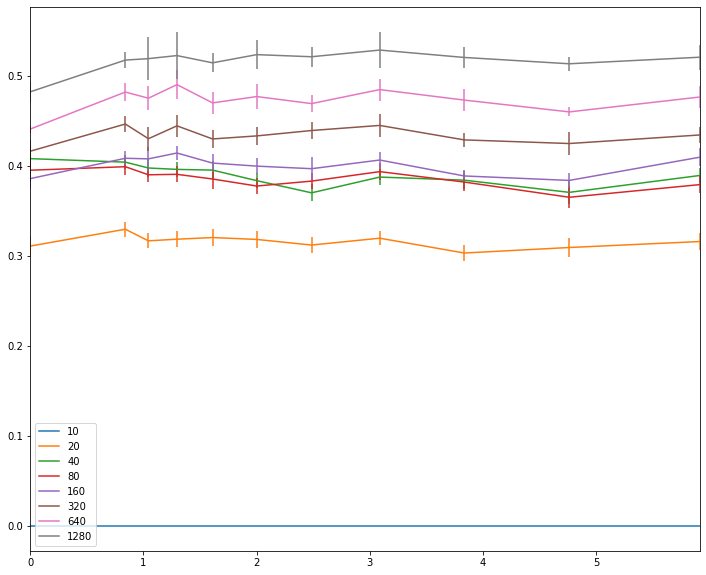

In [9]:
_, ax = plt.subplots(1, 1, figsize=(12, 10))
mean.plot(yerr=err, ax=ax)
#mean2.plot(yerr=err2, ax=ax)

In [10]:
cv_for_test_data, test_data = test_data_to_plottable(test_outputs)
a = {}
for name, dict_plottable in (("cv", cv_for_test_data), ("test", test_data)):
    plottable = pd.DataFrame(dict_plottable)
    mean, err = plottable_to_mean_err(plottable)
    mean = mean.T.sort_index()
    err = err.T.sort_index()
    a[name] = (mean, err)

pd.to_pickle(a, "~/Programacio/cnn-limits/figures/m10_rbf_test.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Matern Myrtle processing

In [11]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/M10-Matern/fig/rbfmyrtle_v3")

Skipping 1, old_config not found 
Skipping 40, old_config not found 
The model name is Myrtle10_replaced_tick_v3_sweep
Processing 35
Counter({1.0: 1})
Processing 4
Counter({0.0: 1})
Processing 19
Counter({0.0: 1})
Processing 9
Counter({0.0: 1})
Processing 37
Counter({0.0: 1})
Processing 28
Counter({1.0: 1})
Processing 16
Counter({0.0: 1})
Processing 6
Counter({1.0: 1})
Processing 18
Counter({1.0: 1})
Processing 3
Counter({0.0: 1})
Processing 33
Counter({1.0: 1})
Processing 43
Counter({0.0: 1})
Processing 38
Counter({0.0: 1})
Processing 15
Counter({0.0: 1})
Processing 32
Counter({0.0: 1})
Processing 13
Counter({0.0: 1})
Processing 29
Counter({0.0: 1})
Skipping _sources, old_config not found 
Processing 31
Counter({0.0: 1})
Processing 20
Counter({0.0: 1})
Processing 10
Counter({0.0: 1})
Processing 30
Counter({0.0: 1})
Processing 11
Counter({0.0: 1})
Processing 7
Counter({1.0: 1})
Processing 44
Counter({0.0: 1})
Processing 36
Counter({0.0: 1})
Processing 39
Counter({0.0: 1})
Processing 21

In [12]:
dict_plottable = cv_data_to_plottable(outputs)
if None in dict_plottable:
    v = dict_plottable[None]  # None means 0 lengthscale, because it's independent
    del dict_plottable[None]
    dict_plottable[0.0] = v
plottable = pd.DataFrame(dict_plottable)
mean = plottable.applymap(np.mean)
mean, err = plottable_to_mean_err(plottable)

mean = mean.T.sort_index()
err = err.T.sort_index()

pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/m10_matern_cv.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


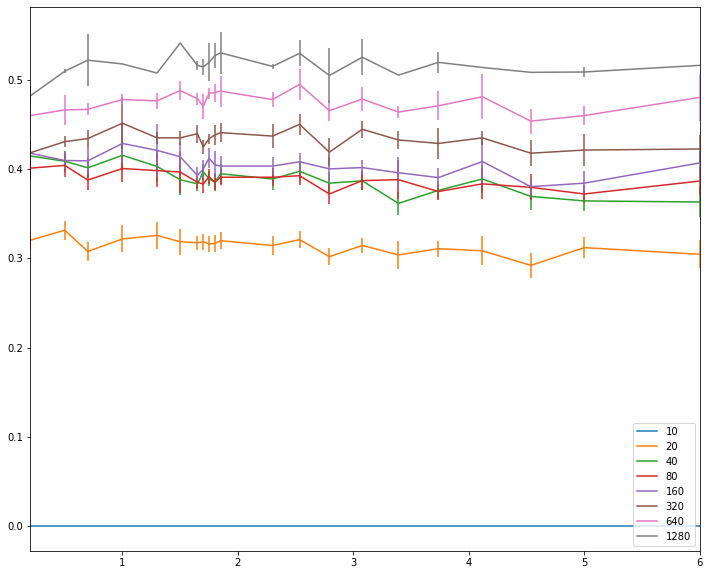

In [13]:
mean.plot(yerr=err, figsize=(12, 10))

# CNTK14 processing

In [14]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/CNTK14/fig/rbfmyrtle_v3",
                                   test_name="cartwright_3")

The model name is CNTK14_sweep
Processing 1
Processing 4
Processing cartwright_3
Found test run_dir: cartwright_3
Processing 9
Processing 6
Processing 3
Skipping 15, old_config not found 
Processing 13
Skipping _sources, old_config not found 
Skipping 10, old_config not found 
Processing 11
Processing 7
Processing 2
Processing 12
Processing 14
Processing poisson_8
Processing 5
Processing 8


In [15]:
outputs[None]

,10,20,40,80,160,320,640,1280,2560,5120,10240
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.20000000298023224, 0.15000000223517418, 0.1...","[0.30000000447034836, 0.15000000223517418, 0.1...","[0.3125000046566129, 0.27500000409781933, 0.25...","[0.33125000493600965, 0.23125000344589353, 0.2...","[0.31875000474974513, 0.3062500045634806, 0.33...","[0.36093750537838787, 0.3546875052852556, 0.37...","[0.4031250060070306, 0.42656250635627657, 0.41...","[0.48671875725267455, 0.4804687571595423, 0.47...","[0.5228515702910954, 0.5003906324564014, 0.513...",[0.5632812583935447]
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05000000074505806, 0.10000000149011612, 0.3...","[0.3250000048428774, 0.27500000409781933, 0.17...","[0.13750000204890966, 0.21250000316649675, 0.2...","[0.26875000400468707, 0.21250000316649675, 0.3...","[0.3125000046566129, 0.3125000046566129, 0.318...","[0.39218750584404916, 0.3718750055413693, 0.34...","[0.4023437559953891, 0.4218750062864274, 0.416...","[0.4746093820722308, 0.46250000689178705, 0.46...","[0.5126953201397555, 0.510937507613562, 0.5095...",[0.5650390709197382]
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05000000074505806, 0.10000000149011612, 0.1...","[0.27500000409781933, 0.2500000037252903, 0.15...","[0.3250000048428774, 0.27500000409781933, 0.23...","[0.3125000046566129, 0.23750000353902578, 0.34...","[0.30937500461004674, 0.29062500433064997, 0.2...","[0.35781250533182174, 0.3515625052386895, 0.34...","[0.3882812557858415, 0.41406250617001206, 0.42...","[0.48906250728759915, 0.4621093818859663, 0.46...","[0.522656257788185, 0.5199218827474397, 0.5095...",[0.5625000083819032]
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.10000000149011612, 0.0, 0.050000000745...","[0.20000000298023224, 0.2500000037252903, 0.20...","[0.3125000046566129, 0.23750000353902578, 0.26...","[0.27500000409781933, 0.25625000381842256, 0.3...","[0.31875000474974513, 0.32187500479631126, 0.3...","[0.3375000050291419, 0.38437500572763383, 0.37...","[0.4078125060768798, 0.4273437563679181, 0.410...","[0.4699218820023816, 0.4644531319208909, 0.462...","[0.5261718828405719, 0.5048828200233402, 0.517...",[0.5625976646333584]
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.05000000074505806, 0.20000000298023224, 0.1...","[0.20000000298023224, 0.3250000048428774, 0.20...","[0.27500000409781933, 0.36250000540167093, 0.3...","[0.33125000493600965, 0.2937500043772161, 0.30...","[0.2937500043772161, 0.3031250045169145, 0.334...","[0.33906250505242497, 0.4078125060768798, 0.37...","[0.38984375580912456, 0.42343750630971044, 0.4...","[0.4722656320373062, 0.46601563194417395, 0.46...","[0.5253906328289304, 0.5162109451921424, 0.507...",[0.5626953208848136]
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.20000000298023224, 0.2500000037252903, 0.10...","[0.3250000048428774, 0.2500000037252903, 0.200...","[0.3125000046566129, 0.27500000409781933, 0.22...","[0.23750000353902578, 0.2625000039115548, 0.33...","[0.34062500507570803, 0.28750000428408384, 0.3...","[0.35781250533182174, 0.34843750519212335, 0.3...","[0.3812500056810677, 0.3976562559255399, 0.410...","[0.467578131967457, 0.45898438183940016, 0.462...","[0.52519532032602, 0.5123046951339347, 0.52656...",[0.5634765708964551]
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.2500000037252903, 0.10000000149011612, 0.05...","[0.30000000447034836, 0.3500000052154064, 0.22...","[0.30000000447034836, 0.3250000048428774, 0.18...","[0.2937500043772161, 0.28750000428408384, 0.30...","[0.30937500461004674, 0.32187500479631126, 0.3...","[0.3546875052852556, 0.37500000558793545, 0.36...","[0.4132812561583705, 0.4390625065425411, 0.432...","[0.4886718822817784, 0.46484375692671165, 0.47...","[0.5351562579744495, 0.5330078204424353, 0.524...",[0.5794921961351065]
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.15000000223517418, 0.15000000223517418, 0.0...","[0.20000000298023224, 0.15000000223517418, 0.2

In [16]:
assert tuple(outputs.keys()) == (None,)
plottable = outputs[None]
mean, err = plottable_to_mean_err(plottable)

mean = mean.sort_index()
err = err.sort_index()

pd.to_pickle((mean, err), "~/Programacio/cnn-limits/figures/cntk14_cv.pkl.gz")

/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


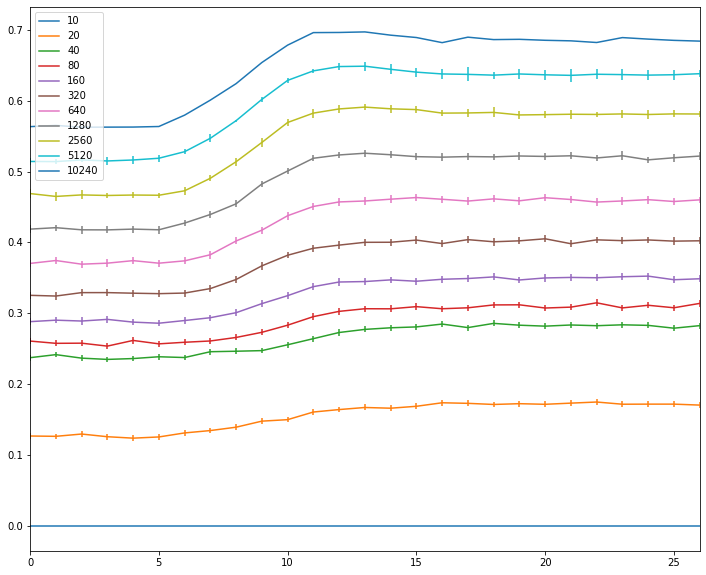

In [17]:
mean.plot(yerr=err, figsize=(12, 10))

In [19]:
outputs, test_outputs = build_data("/scratch/ag919/logs/final_figures/CNTK14/fig",
                                   test_name="cartwright_bugfix_6", skip_incomplete=False)

assert tuple(test_outputs.keys()) == (None,)
cv_for_test_data, test_data = test_outputs[None]

a = {}
for name, dict_plottable in (("cv", cv_for_test_data), ("test", test_data)):
    plottable = pd.DataFrame(dict_plottable)
    mean, err = plottable_to_mean_err(plottable)
    mean = mean.sort_index()
    err = err.sort_index()
    a[name] = (mean, err)

pd.to_pickle(a, "~/Programacio/cnn-limits/figures/cntk14_test.pkl.gz")

Skipping rbfmyrtle_v3, old_config not found 
The model name is CNTK14_sweep
Dropped 21 rows from cartwright_bugfix_6
Processing cartwright_bugfix_6
Found test run_dir: cartwright_bugfix_6
Dropped 27 rows from 15
Index for 15 is Int64Index([], dtype='int64'), different from [ 0 10 11 12 13 26]. Skipping...


/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/homes/ag919/venv/py37/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
a["test"][0]

In [ ]:
a["test"][0].plot(yerr=a['test'][1], figsize=(12, 10))

In [ ]:
c.loc[12, 320][0].shape

In [ ]:
c = pd.read_pickle("/scratch/ag919/logs/final_figures/CNTK14/fig/rbfmyrtle_v3/cartwright_3/n_splits_4/grid_acc.pkl.gz")
d = pd.read_pickle("/scratch/ag919/logs/final_figures/CNTK14/fig/15/n_splits_4/grid_acc.pkl.gz")

In [ ]:
_, ax = plt.subplots(1, 1)

for i in [10 * 2**i for i in range(11)]:
    x,y =map(lambda _x: np.mean(_x, 0), c.loc[25, i])
    ax.plot(np.log(x), y, label=f"{i} line")
ax.set_xlim((-30, np.log(x).max()))

In [ ]:
_, ax = plt.subplots(1, 1)

x,y =map(np.squeeze, c.loc[12, 10240])
ax.plot(np.log(x)-np.log(136.98), y)
ax.plot([np.log(x[y.argmax()])-np.log(136.98) ]*2, [0, 0.7])

x,y =map(np.squeeze, c.loc[26, 10240])
ax.plot([np.log(x[y.argmax()]) ]*2, [0, 0.7])
ax.plot(np.log(x), y)

#ax.set_xlim((-0.00001, 0.0001))
ax.set_xlim(-12.5, -10)

In [ ]:
_, ax = plt.subplots(1, 1)
ax.plot(*map(np.squeeze, a.loc[26, 10240]))
ax.set_xlim((-0.01, 0.1))